In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import os

In [3]:
# Constants
IMAGE_SIZE_1 = 300
IMAGE_SIZE_2 = 300
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
NUM_CLASSES = 27  # Adjust this based on your dataset
DATASET_PATH = "/content/drive/MyDrive/PharmaScope"

In [4]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE_1, IMAGE_SIZE_2),
    batch_size=BATCH_SIZE
)

Found 3495 files belonging to 27 classes.


In [5]:
# Get class names
class_names = dataset.class_names

In [6]:
# Split dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
# Cache, shuffle, and prefetch the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [10]:
efficientnet = EfficientNetB3(include_top=False, input_shape=(300, 300, 3), weights='imagenet')


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
# Freeze the EfficientNetB3 layers
for layer in efficientnet.layers:
    layer.trainable = False

model = models.Sequential([
    data_augmentation,
    efficientnet,
    layers.GlobalAveragePooling2D(),  # This should reduce the dimensions properly
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Adjust NUM_CLASSES according to your dataset
])


In [12]:
# Build the model with the correct input shape
model.build(input_shape=(None, IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS))

In [13]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │          13,851 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,584,330 (44.19 MB)

 Trainable params: 800,795 (3.05 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.4228 - loss: 1.9776 - val_accuracy: 0.8523 - val_loss: 0.5234
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.8271 - loss: 0.5778 - val_accuracy: 0.9347 - val_loss: 0.2705
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.8922 - loss: 0.3648 - val_accuracy: 0.9119 - val_loss: 0.2994
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.9249 - loss: 0.2481 - val_accuracy: 0.9716 - val_loss: 0.1594
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.9227 - loss: 0.2340 - val_accuracy: 0.9659 - val_loss: 0.1386
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.9593 - loss: 0.1461 - val_accuracy: 0.9631 - val_loss: 0.1405
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.9446 - loss: 0.1778 - val_accuracy: 0.9801 - val_loss: 0.0894
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.9532 - loss: 0.1486 - val_accura

In [16]:
# Evaluate the model
scores = model.evaluate(test_ds)
print(f'Test Accuracy: {scores[1]}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 186s 145ms/step - accuracy: 0.9899 - loss: 0.0251
Test Accuracy: 0.9857954382896423


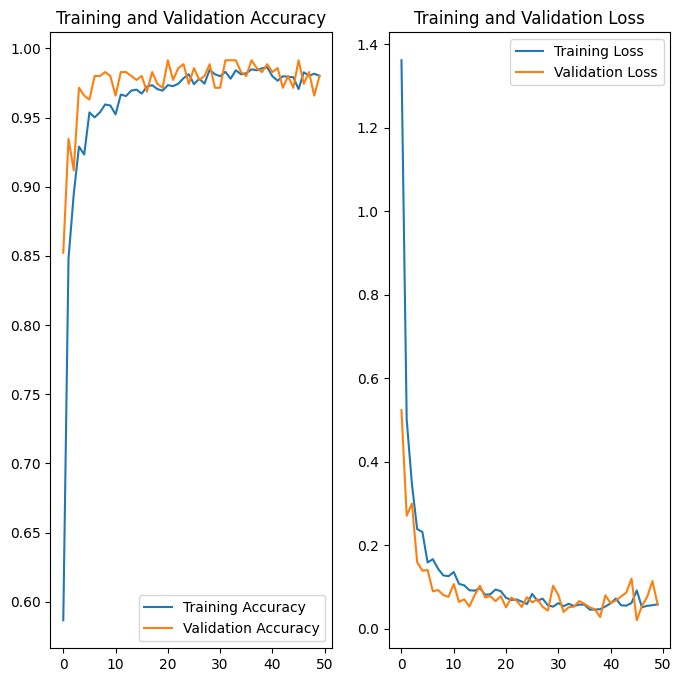

In [17]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [19]:
# Make predictions
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    preds = model.predict(images_batch)
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [20]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8

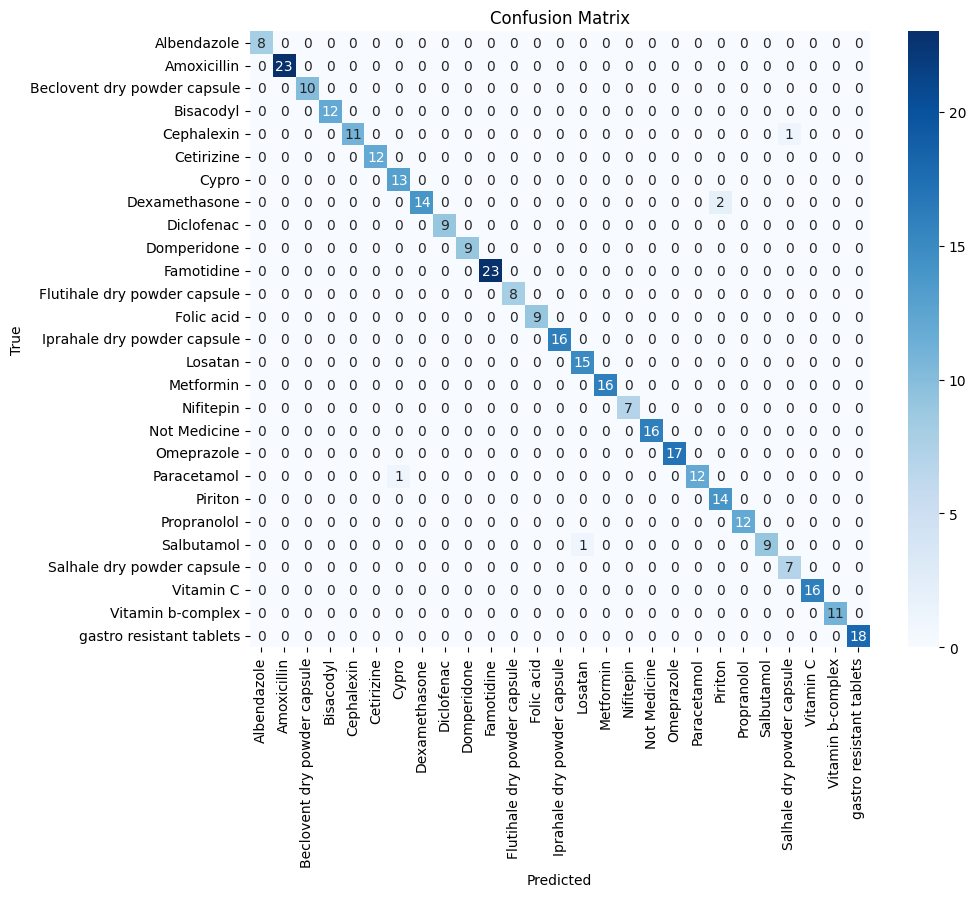

In [21]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Classification report
cr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report")
print(cr)

Classification Report
                              precision    recall  f1-score   support

                 Albendazole       1.00      1.00      1.00         8
                 Amoxicillin       1.00      1.00      1.00        23
Beclovent dry powder capsule       1.00      1.00      1.00        10
                   Bisacodyl       1.00      1.00      1.00        12
                  Cephalexin       1.00      0.92      0.96        12
                  Cetirizine       1.00      1.00      1.00        12
                       Cypro       0.93      1.00      0.96        13
               Dexamethasone       1.00      0.88      0.93        16
                  Diclofenac       1.00      1.00      1.00         9
                 Domperidone       1.00      1.00      1.00         9
                  Famotidine       1.00      1.00      1.00        23
Flutihale dry powder capsule       1.00      1.00      1.00         8
                  Folic acid       1.00      1.00      1.00        

In [23]:
# Precision, recall, F1 score, and accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Accuracy: {accuracy}')

Precision: 0.9872412743506493
Recall: 0.9857954545454546
F1 Score: 0.9857952442164813
Accuracy: 0.9857954545454546


In [24]:
# Save the model
model.save(f"/content/drive/MyDrive/models/enb3.h5")

TypeError: cannot pickle 'module' object

In [27]:
# Save the model
existing_versions = [int(i) for i in os.listdir("/content/drive/MyDrive/models/") if i.isdigit()]
model_version = max(existing_versions + [0]) + 1
model.save(f"/content/drive/MyDrive/models/enb3.keras") # Add .keras extension

In [26]:
import tensorflow as tf
print(tf.__version__)


2.17.0
